Getting all file paths from directory: /media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D
Total files found: 56

Processing batch 1 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.304', 'ZZ.FWU1.10.HHE.D.2019.305', 'ZZ.FWU1.10.HHE.D.2019.306']


/tmp/ipykernel_750/4179782295.py:24: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time = pd.date_range(start=start_time.datetime, periods=len(data), freq=f'{1/sampling_rate}S')


Batch read. Total rows: 64800000
Creating plot...


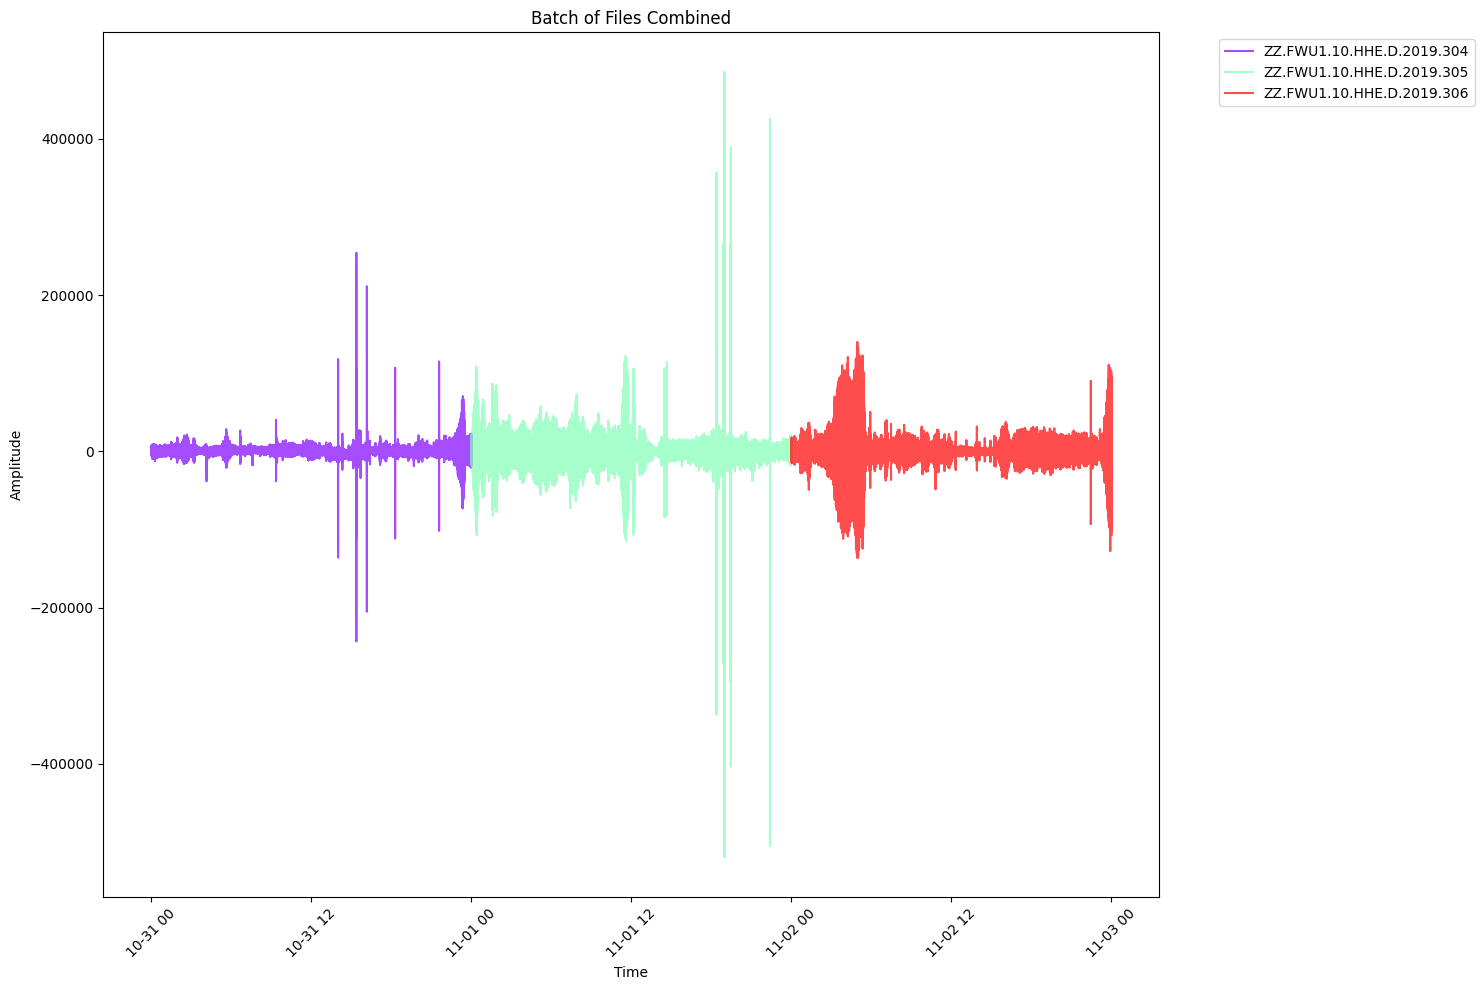


Processing batch 2 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.307', 'ZZ.FWU1.10.HHE.D.2019.308', 'ZZ.FWU1.10.HHE.D.2019.309']
Batch read. Total rows: 59394817
Creating plot...


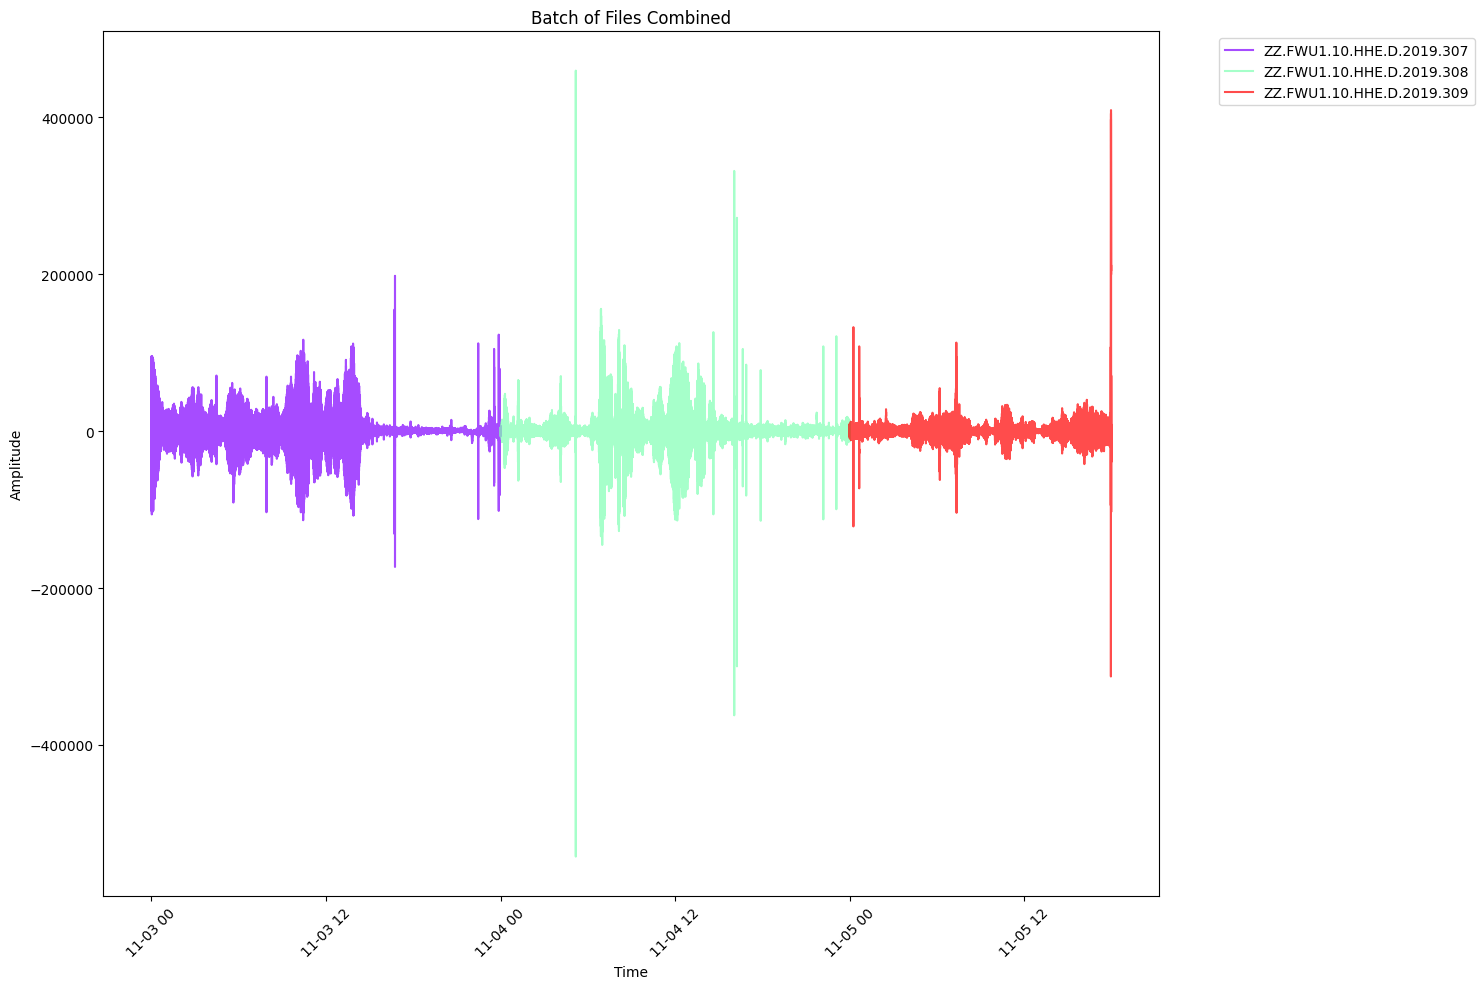


Processing batch 3 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.310', 'ZZ.FWU1.10.HHE.D.2019.311', 'ZZ.FWU1.10.HHE.D.2019.312']
Batch read. Total rows: 64800000
Creating plot...


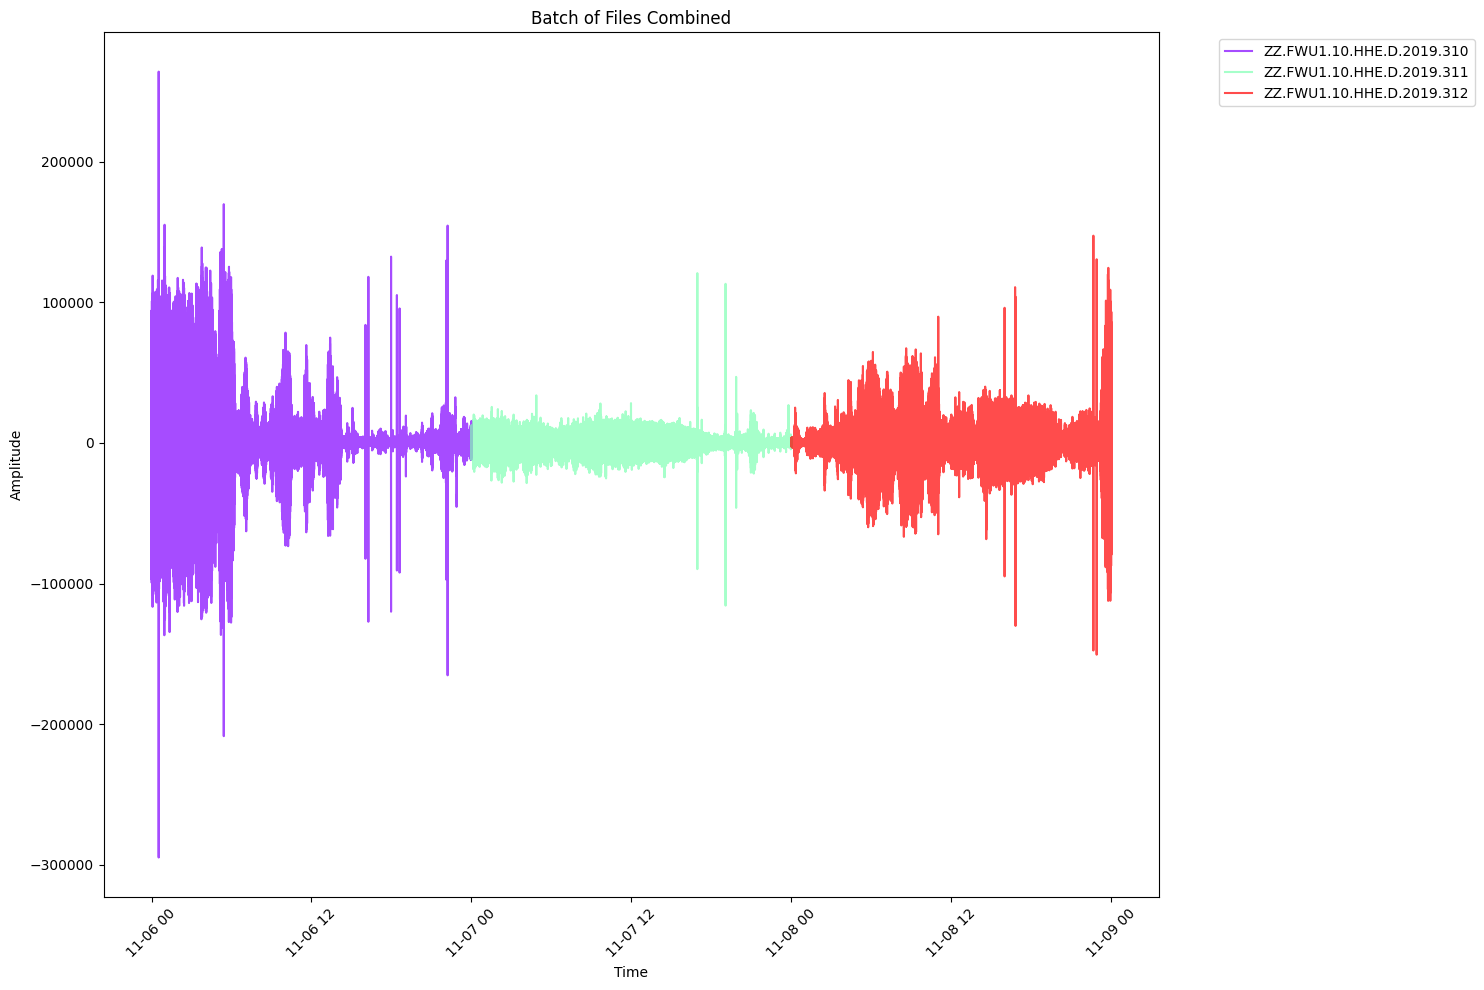


Processing batch 4 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.313', 'ZZ.FWU1.10.HHE.D.2019.314', 'ZZ.FWU1.10.HHE.D.2019.315']
Batch read. Total rows: 64800000
Creating plot...


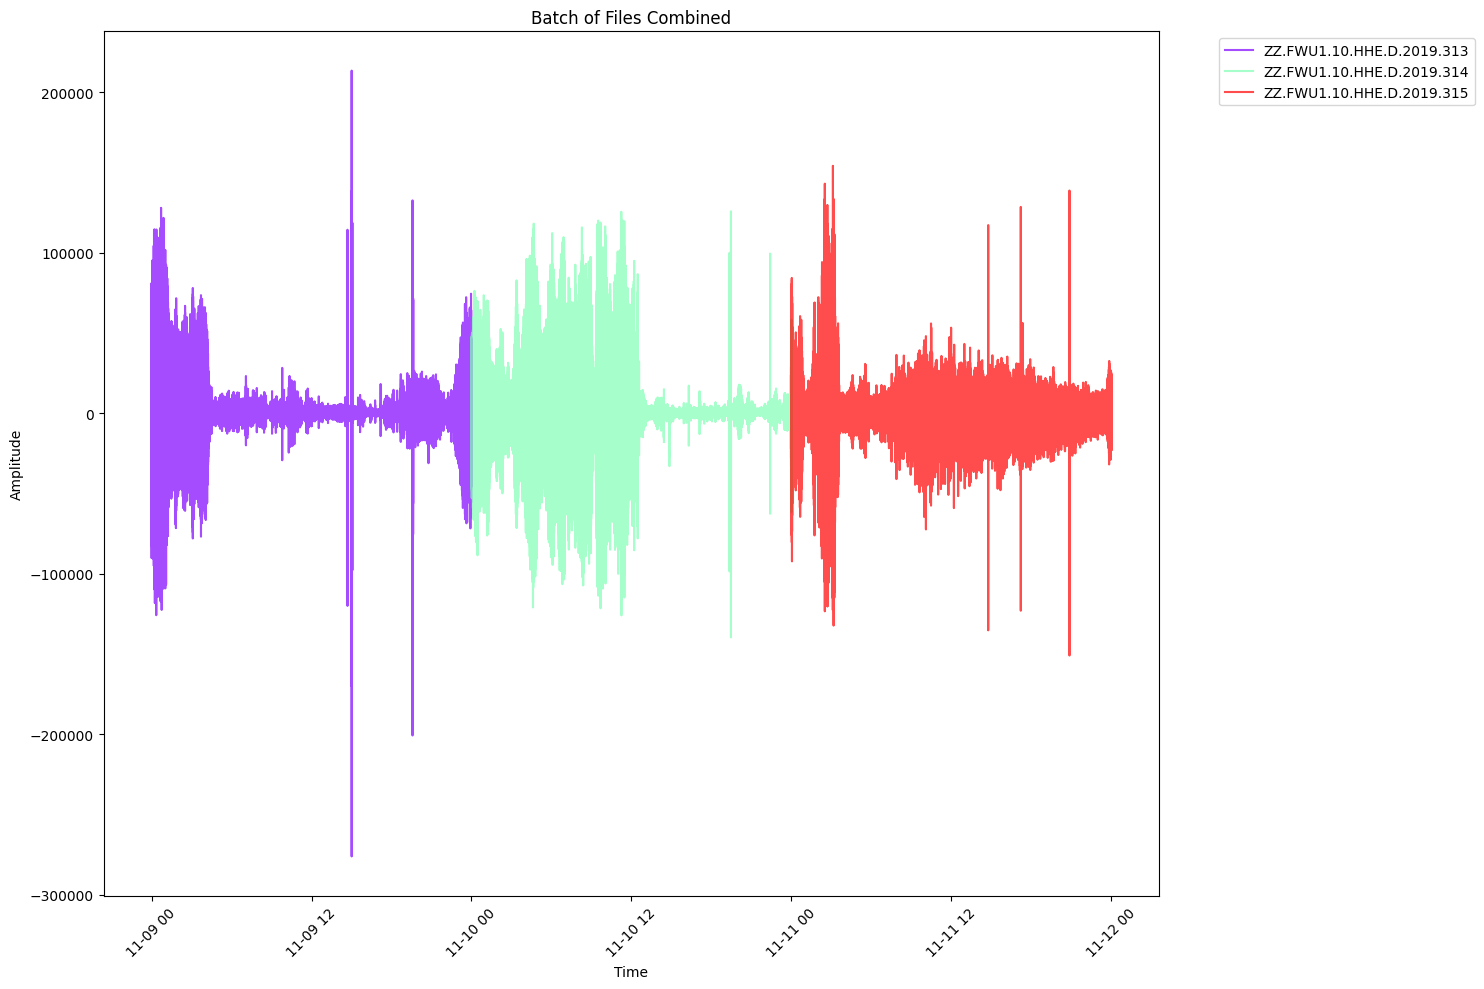


Processing batch 5 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.316', 'ZZ.FWU1.10.HHE.D.2019.317', 'ZZ.FWU1.10.HHE.D.2019.318']
Batch read. Total rows: 64800000
Creating plot...


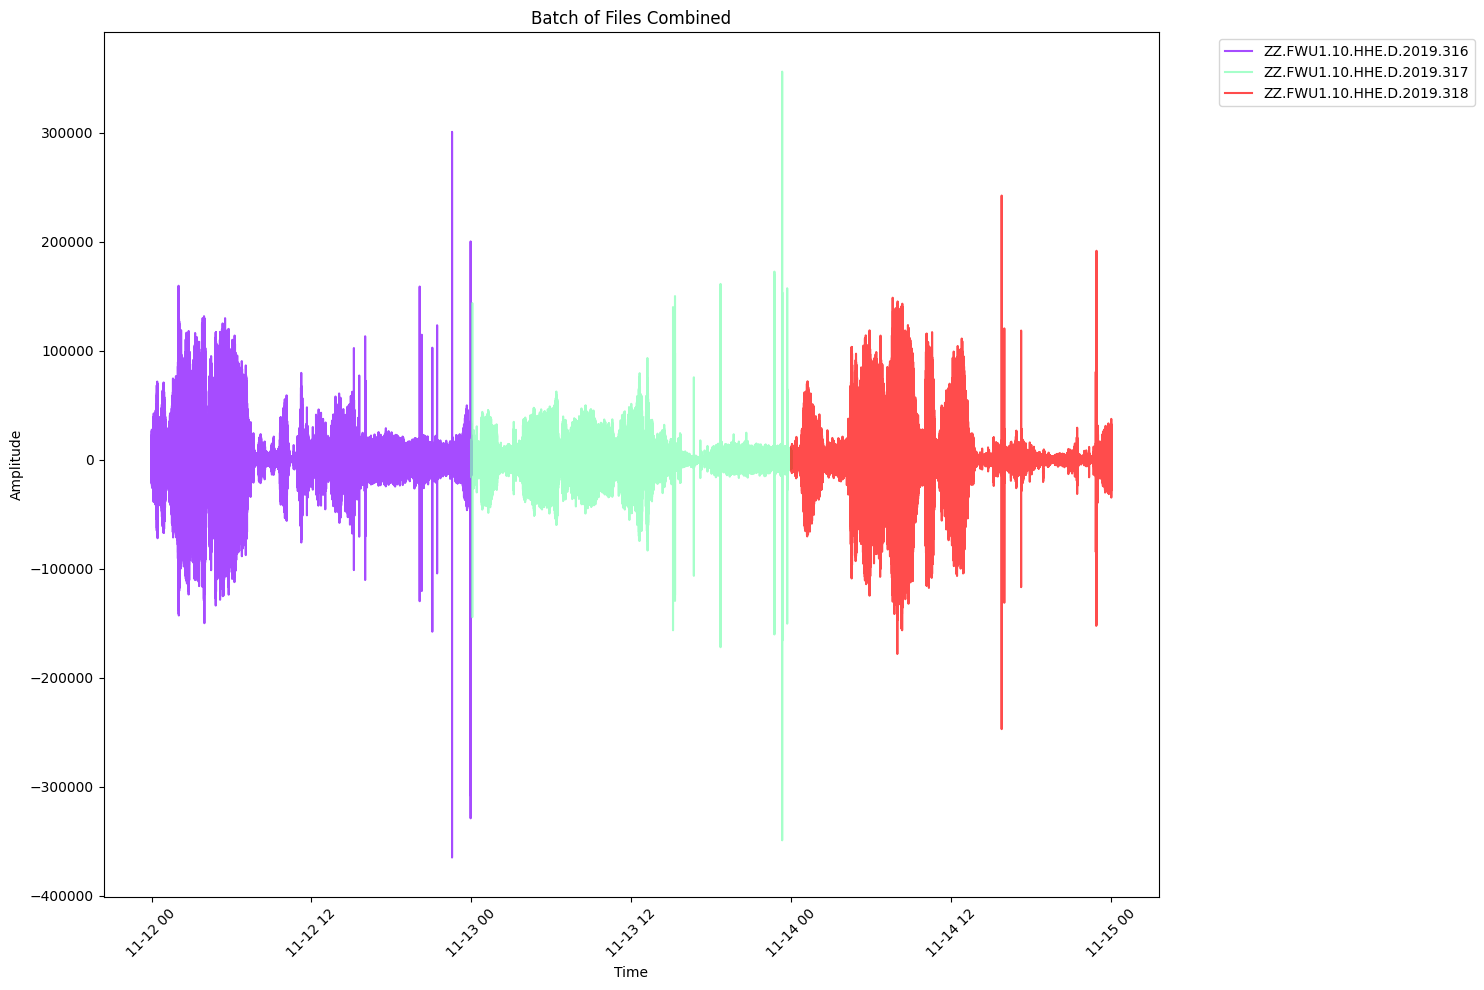


Processing batch 6 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.319', 'ZZ.FWU1.10.HHE.D.2019.320', 'ZZ.FWU1.10.HHE.D.2019.321']
Batch read. Total rows: 64800000
Creating plot...


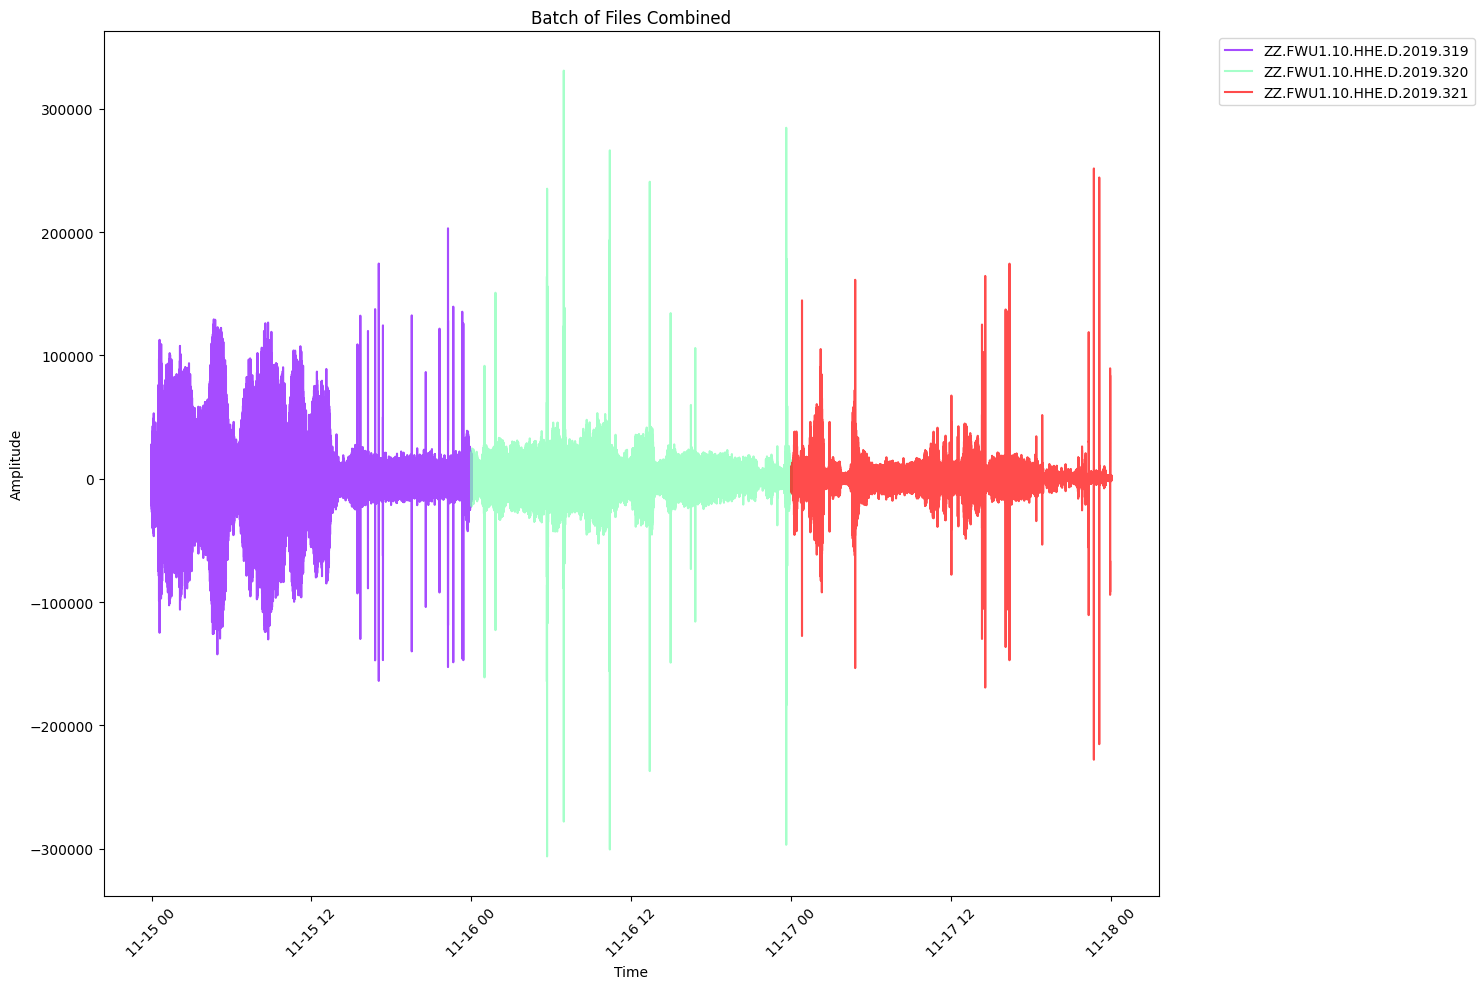


Processing batch 7 of 19
Files in this batch: ['ZZ.FWU1.10.HHE.D.2019.322', 'ZZ.FWU1.10.HHE.D.2019.323', 'ZZ.FWU1.10.HHE.D.2019.324']
Batch read. Total rows: 64800000
Creating plot...


: 

In [ ]:
import os
import matplotlib.pyplot as plt
from obspy import read
import pandas as pd
import numpy as np
import dask.dataframe as dd
import dask.array as da
from dask.diagnostics import ProgressBar
import gc

def get_all_file_paths(directory):
    """Collects all file paths from the specified directory and returns a list of those paths."""
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

def read_file_to_dataframe(file_path):
    try:
        st = read(file_path)
        data = st[0].data
        start_time = st[0].stats.starttime
        sampling_rate = st[0].stats.sampling_rate
        
        time = pd.date_range(start=start_time.datetime, periods=len(data), freq=f'{1/sampling_rate}S')
        df = pd.DataFrame({'time': time, 'data': data, 'file': os.path.basename(file_path)})
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None

def plot_batch_data(df):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Create a color map for different files
    unique_files = df['file'].unique().compute()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_files)))

    for file, color in zip(unique_files, colors):
        file_df = df[df['file'] == file]
        ax.plot(file_df['time'], file_df['data'], label=file, color=color, alpha=0.7)

    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.set_title('Batch of Files Combined')
    ax.tick_params(axis='x', rotation=45)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    directory = '/media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D'
    batch_size = 3

    print(f"Getting all file paths from directory: {directory}")
    all_file_paths = get_all_file_paths(directory)

    print(f"Total files found: {len(all_file_paths)}")

    for i in range(0, len(all_file_paths), batch_size):
        batch = all_file_paths[i:i + batch_size]
        print(f"\nProcessing batch {i//batch_size + 1} of {len(all_file_paths)//batch_size + 1}")
        print(f"Files in this batch: {[os.path.basename(path) for path in batch]}")

        batch_dfs = []
        for file_path in batch:
            df = read_file_to_dataframe(file_path)
            if df is not None:
                batch_dfs.append(df)

        if batch_dfs:
            # Convert pandas DataFrames to Dask DataFrame
            ddf = dd.concat([dd.from_pandas(df, npartitions=1) for df in batch_dfs])
            
            print(f"Batch read. Total rows: {ddf.shape[0].compute()}")
            print("Creating plot...")
            
            # Compute the plot
            with ProgressBar():
                plot_batch_data(ddf)
            
            # Clear memory
            del ddf
            gc.collect()

    print("Processing complete.")

if __name__ == "__main__":
    main()

## Read Single File on (Enter)


Starting processing. Root directory: /media/rsbiim/Extreme Pro/ZZ_clean/FWU1/, Chunk size: 1000000

Processing file: /media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D/ZZ.FWU1.10.HHE.D.2019.304
File read successfully. Number of traces: 1
Processing chunk 1
DataFrame shape: (1000000, 2)
Creating plot: ZZ.FWU1.10.HHE.D.2019.304 - Chunk 1


/tmp/ipykernel_21264/1285540354.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time = pd.date_range(start=start_time.datetime, periods=len(chunk), freq=f'{1/sampling_rate}S')


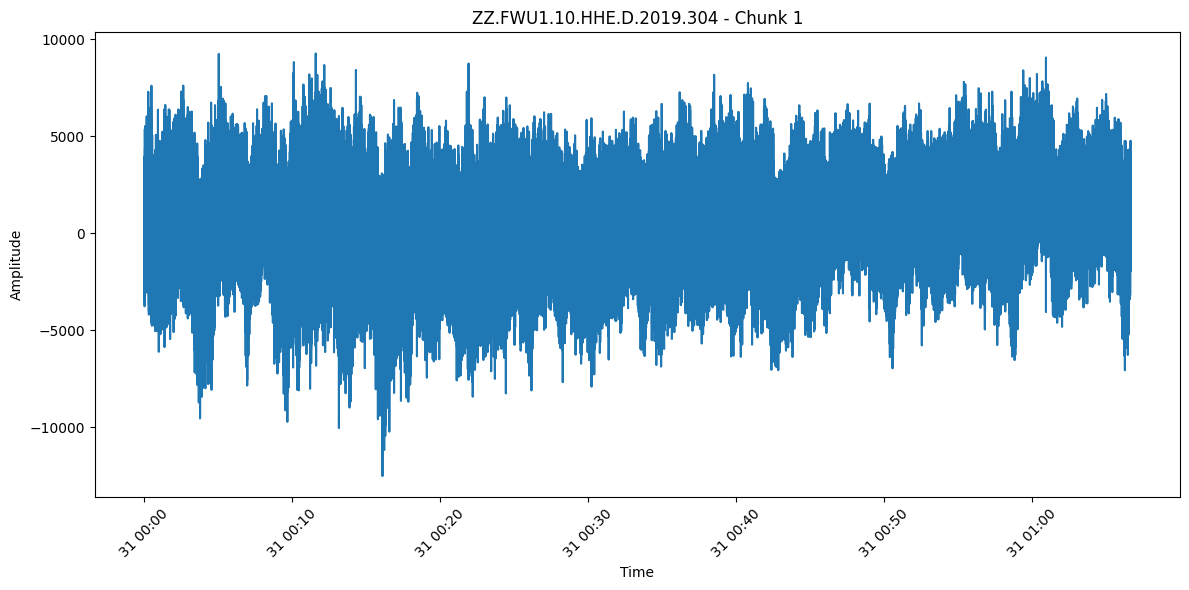

Plot displayed. Press Enter to continue...


In [ ]:
import os
import matplotlib.pyplot as plt
from obspy import read
import pandas as pd

def read_miniseed_to_dataframe(file_path, chunk_size=1000000):
    st = read(file_path)
    data = st[0].data
    start_time = st[0].stats.starttime
    sampling_rate = st[0].stats.sampling_rate
    
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        time = pd.date_range(start=start_time.datetime, periods=len(chunk), freq=f'{1/sampling_rate}S')
        yield pd.DataFrame({'time': time, 'data': chunk})
        start_time += len(chunk) / sampling_rate

def plot_data(df, title=""):
    plt.figure(figsize=(12,6))
    plt.plot(df['time'], df['data'])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    root_directory = '/media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D'
    chunk_size = 1000000  # Adjust this based on your memory constraints

    print(f"Starting processing. Root directory: {root_directory}, Chunk size: {chunk_size}")

    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            print(f"\nProcessing file: {file_path}")
            
            try:
                st = read(file_path)
                print(f"File read successfully. Number of traces: {len(st)}")
                
                for i, df in enumerate(read_miniseed_to_dataframe(file_path, chunk_size)):
                    print(f"Processing chunk {i+1}")
                    print(f"DataFrame shape: {df.shape}")
                    
                    title = f"{filename} - Chunk {i+1}"
                    print(f"Creating plot: {title}")
                    plot_data(df, title)
                    
                    print("Plot displayed. Press Enter to continue...")
                    
                    input()  # Wait for user input before continuing
                    
                    del df  # Clear the DataFrame to free up memory
            
            except Exception as e:
                print(f"Error processing file {file_path}: {str(e)}")

    print("Processing complete.")

if __name__ == "__main__":
    main()


In [ ]:
import os
import matplotlib.pyplot as plt
from obspy import read
import pandas as pd
import numpy as np

def get_all_file_paths(directory):
    """
    Collects all file paths from the specified directory and returns a list of those paths.
    """
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

def read_file_to_dataframe(file_path):
    try:
        st = read(file_path)
        data = st[0].data
        start_time = st[0].stats.starttime
        sampling_rate = st[0].stats.sampling_rate

        time = pd.date_range(start=start_time.datetime, periods=len(data), freq=f'{1/sampling_rate}S')
        df = pd.DataFrame({'time': time, 'data': data, 'file': os.path.basename(file_path)})
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None

def plot_batch_data(df):
    plt.figure(figsize=(15, 10))

    # Create a color map for different files
    unique_files = df['file'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_files)))

    for file, color in zip(unique_files, colors):
        file_df = df[df['file'] == file]
        plt.plot(file_df['time'], file_df['data'], label=file, color=color, alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Batch of Files Combined')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    directory = '/media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D'
    batch_size = 20  # Adjust this based on your preference

    print(f"Getting all file paths from directory: {directory}")
    all_file_paths = get_all_file_paths(directory)

    print(f"Total files found: {len(all_file_paths)}")

    current_batch = []
    for i, file_path in enumerate(all_file_paths):
        print(f"\nProcessing file {i+1} of {len(all_file_paths)}")
        print(f"File: {file_path}")

        df = read_file_to_dataframe(file_path)
        if df is not None:
            print(f"File read. Total rows: {len(df)}")
            current_batch.append(df)

        if (i + 1) % batch_size == 0 or i == len(all_file_paths) - 1:
            if current_batch:
                batch_df = pd.concat(current_batch, ignore_index=True)
                print("Creating plot...")
                plot_batch_data(batch_df)
                del batch_df  # Clear the DataFrame to free up memory
                current_batch.clear()

    print("Processing complete.")

if __name__ == "__main__":
    main()